## Portfolio Exercise Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their candidates.   The data for this exercise consists of about 120,000 data points split in 2:1 ratio among training and test files. Each data point includes one column indicating whether or not an individual was sent a promotion for a specific product, and one column indicating whether or not that individual eventually purchased that product. Each individual also had seven additional features associated with them.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user.  Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

Ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group.

* **Net Incremental Revenue (NIR)**

The total number of purchasers that received the promotion times 10 minus the number of promotions given times 0.15 minus the number of purchasers who were not given the promotion times 10.

For a full description of what starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the **promotion_strategy** function to pass to the **test_results** function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers.  

|   | Actual      |    |    | 
|---|-------------|----|----|
| **Predicted**   | Yes| No |  
| Yes             | **I**   | **II**|  
| No              | **III** | **IV**|  

The metrics are only being compared for the individual's we predict should obtain the promotion - that is quadrants I and II here.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equal participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 


Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final test_results function.

In [1]:
# load in packages
from test_results import test_results, score
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


### 1. check data problem

In [2]:
train_data.isna().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [3]:
train_data.duplicated().sum()

0

### 2. some EDA

In [4]:
train_data.nunique()

ID           84534
Promotion        2
purchase         2
V1               4
V2           84518
V3              40
V4               2
V5               4
V6               4
V7               2
dtype: int64

In [5]:
train_data.Promotion.value_counts()

Promotion
Yes    42364
No     42170
Name: count, dtype: int64

In [6]:
train_data.purchase.value_counts()

purchase
0    83494
1     1040
Name: count, dtype: int64

In [7]:
train_data.groupby('Promotion').purchase.mean()

Promotion
No     0.007565
Yes    0.017019
Name: purchase, dtype: float64

In [8]:
0.017/0.0075

2.266666666666667

#### the main target is to find the customers who are sensitive to the promotion, which means there should be some differences in the rate of making purchase between treated vs untreated group; keep in mind that overall, the increase of making purchase is about 2.26

In [9]:
def check_ratio(col, annot=True):
    '''
      compute and show the ratio of purchasing customers between the ones receive/not receive promotion
      also compare the difference 
    '''
    fig, axs = plt.subplots(2,1)
    fig.tight_layout()
    axs = axs.flatten()
    tmp = train_data.groupby(['Promotion', col]).purchase.mean().unstack(level=1)
    sns.heatmap(tmp, annot=annot, ax=axs[0])
    tmp = pd.DataFrame(tmp.iloc[1,:] / tmp.iloc[0,:] - 2.26).reset_index()
    tmp.columns = [col, 'ratio']
    sns.barplot(tmp, y='ratio', x=col)
    plt.grid(visible=True, which='major', axis='y')
    plt.xticks(rotation=90)
    return tmp

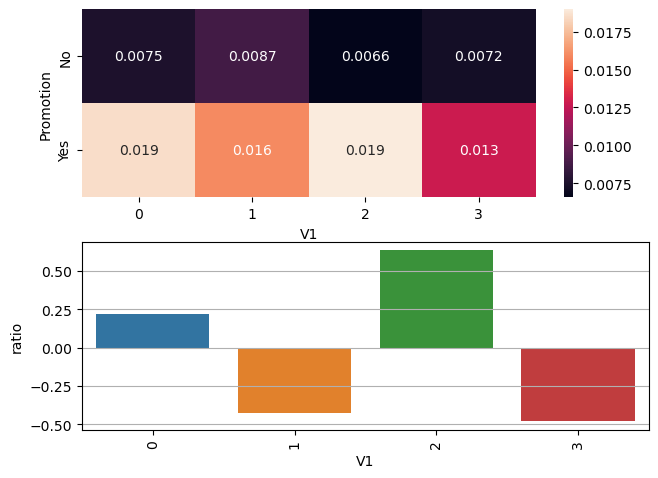

In [10]:
tmp = check_ratio('V1')

,V3,ratio
0,-1.684550,4.578262
1,-1.597972,2.468819
2,-1.511395,0.846884
3,-1.424817,0.907614
4,-1.338239,-0.878459
5,-1.251661,1.219248
6,-1.165083,-0.517534
7,-1.078506,1.845523
8,-0.991928,-0.391696
9,-0.905350,-0.523286


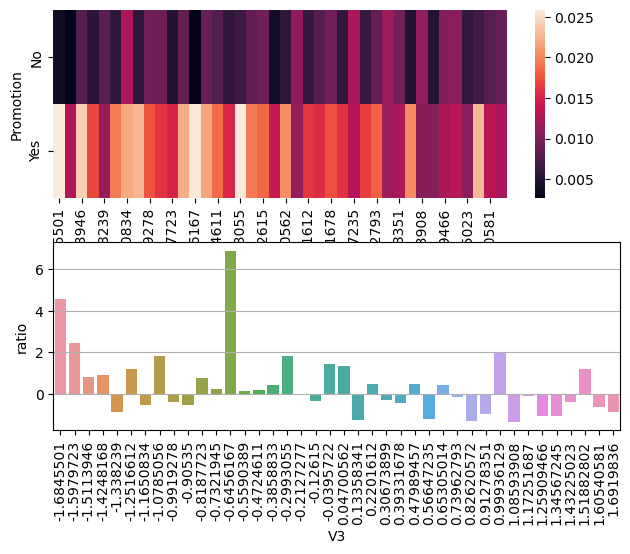

In [11]:
check_ratio('V3', annot=False)

,V4,ratio
0,1,-1.299022
1,2,0.565095


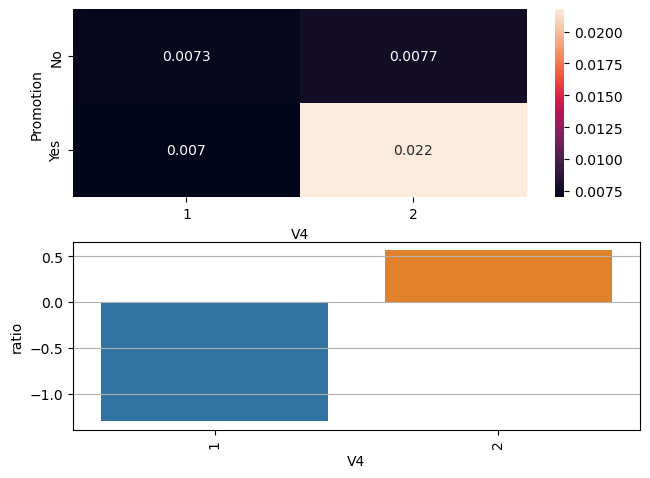

In [12]:
check_ratio('V4')

,V5,ratio
0,1,0.666700
1,2,-0.936159
2,3,0.633588
3,4,-0.215174


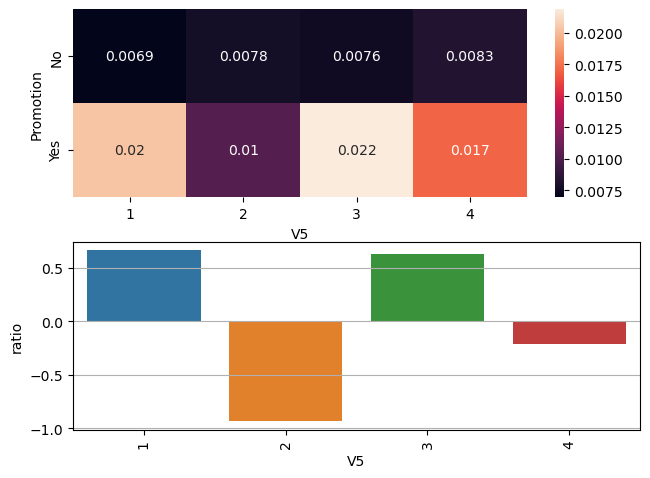

In [13]:
check_ratio('V5')

,V6,ratio
0,1,0.230963
1,2,-0.357820
2,3,0.131479
3,4,0.012240


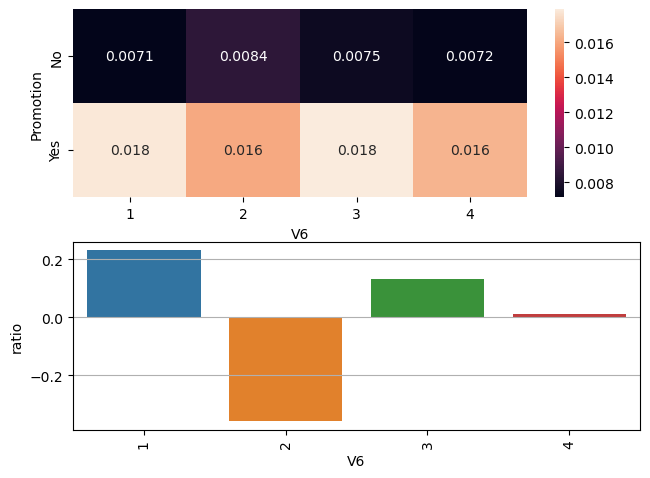

In [14]:
check_ratio('V6')

,V7,ratio
0,1,0.339780
1,2,-0.141653


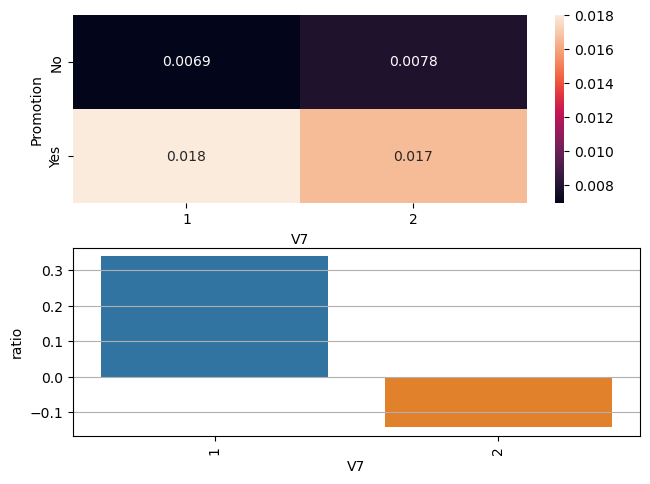

In [15]:
check_ratio('V7')

<Axes: xlabel='V2', ylabel='Density'>

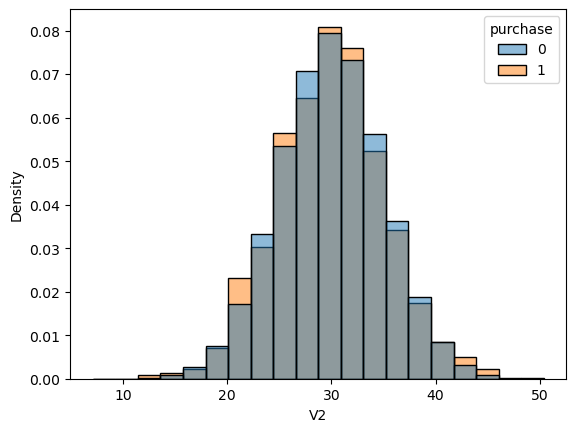

In [16]:
sns.histplot(train_data, x='V2', hue='purchase', common_norm=False, stat='density', bins=20)

In [17]:
train_data['V2_bin'] = pd.qcut(train_data['V2'], q=20)

,V2_bin,ratio
0,"(7.103, 21.718]",-0.315063
1,"(21.718, 23.579]",-0.730616
2,"(23.579, 24.793]",2.134597
3,"(24.793, 25.772]",0.766387
4,"(25.772, 26.592]",1.091152
5,"(26.592, 27.347]",-0.592549
6,"(27.347, 28.055]",0.327867
7,"(28.055, 28.715]",-0.202788
8,"(28.715, 29.355]",0.149652
9,"(29.355, 29.98]",-0.882251


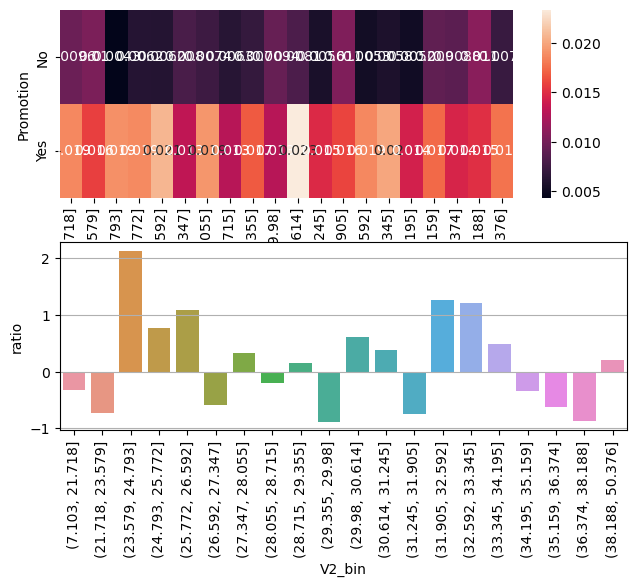

In [18]:
check_ratio('V2_bin')

#### seems all parameters are somewhat useful; for V2 and V3 which have a lot of values, it also doesn't seem to concentrate on certain groups; so a brute force classifier may be good enough 

### 3. understand the metrics
#### the metrics are very specific to this problem; it's also not super clear why only quadrants I and II are used, maybe that means the test set is already optimized somehow?

In [19]:
def myscore(df):
    '''
      code up the irr and nir score
    '''
    n_treat = (df['Promotion'] == 'Yes').sum()
    n_ctrl = len(df) - n_treat
    n_treat_purch = df.loc[df['Promotion'] == 'Yes', 'purchase'].sum()
    n_ctrl_purch = df.loc[df['Promotion'] == 'No', 'purchase'].sum()
    print(n_treat, n_ctrl, n_treat_purch, n_ctrl_purch)
    irr = n_treat_purch / (n_treat+1e-6) - n_ctrl_purch / (n_ctrl+1e-6)
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return irr, nir

In [20]:
test_data = pd.read_csv('data/Test.csv')

In [21]:
myscore(train_data)

42364 42170 721 319


(0.009454547819550352, -2334.5999999999995)

In [22]:
myscore(test_data)

20748 20902 339 141


(0.009593158277785351, -1132.1999999999998)

#### Hmm, it doesn't seem the test data is optimized in any way, which makes the metric computed only on quadrants I and II very strange; anyway, it's what the request is, let's make a scorer based on that

### 4. build the model

In [23]:
train_data = pd.read_csv('./data/training.csv')

In [24]:
class Preprocess(BaseEstimator, TransformerMixin):
    '''
      simply replace the Promotion into 1 and 0, and pick out the features
    '''
#     def __init__(self, cat=True):
#         self.cat = cat
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        df['Promotion'] = np.where(df['Promotion']=='Yes',1,0)
        df = df[['V1','V2','V3','V4','V5','V6','V7','Promotion']]
#         if cat: #this actually makes no difference at all!
#             df = df.astype({col:'category' for col in ['V1','V3','V4','V5','V6','V7']})
        return df

class RandomForestClassifier_wrapper(BaseEstimator, TransformerMixin):
    '''
      a wrapper around random forest so it can transform input input probability
    '''
    def __init__(self, min_samples_leaf=100):
        self.min_samples_leaf = min_samples_leaf
        self.clf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, class_weight='balanced', random_state=42)
    
    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
    
    def score(self, X, y):
        self.clf.score(X, y)
    
    def transform(self, X):
        return self.clf.predict_proba(X)[:,1]

class AdjustP(BaseEstimator, TransformerMixin):
    '''
      maybe it is useful to adjust the p in classification?
    '''
    def __init__(self, p=0.5):
        self.p = p
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        y = np.where(X > self.p, 1, 0)
        return y

In [25]:
cached_dir = mkdtemp()

pipeline = Pipeline([
    ('preprocess', Preprocess()),
    ('clf', RandomForestClassifier_wrapper()),
    ('adjustp', AdjustP())
], memory=cached_dir)

In [26]:
pipeline.get_params()

{'memory': '/var/folders/h9/t5gv56tx3wl0wk4czyrvf36m0000gn/T/tmpl5h1zlp6',
 'steps': [('preprocess', Preprocess()),
  ('clf', RandomForestClassifier_wrapper()),
  ('adjustp', AdjustP())],
 'verbose': False,
 'preprocess': Preprocess(),
 'clf': RandomForestClassifier_wrapper(),
 'adjustp': AdjustP(),
 'clf__min_samples_leaf': 100,
 'adjustp__p': 0.5}

In [27]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df = df.copy()
    df['Promotion'] = 'Yes'
    pred_with_promotion = clf.predict(df)
    df['Promotion'] = 'No'
    pred_without_promotion = clf.predict(df)
    df['treat'] = 'No'
    df.loc[(pred_with_promotion == 1) & (pred_without_promotion == 0), 'treat'] = 'Yes'
    promotion = df['treat'].values
    return promotion

In [28]:
param_grids = {'min_samples_leaf': [10,50,70,100,120,150,200],
               'p': [0.3,0.4,0.5,0.6,0.7]}

In [29]:
cv_results = pd.DataFrame(columns=['min_samples_leaf','p','irr_mean','irr_std','nir_mean','nir_std'])
for min_samples_leaf, p in product(param_grids['min_samples_leaf'],
                                   param_grids['p']):
    clf = clone(pipeline)
    print(f"doing {min_samples_leaf}, {p}")
    clf.set_params(clf__min_samples_leaf = min_samples_leaf,
                   adjustp__p = p)
    irr_outputs, nir_outputs = [], []
    for train_idx, test_idx in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(train_data, train_data.purchase):
        train_split = train_data.iloc[train_idx]
        test_split = train_data.iloc[test_idx]
        clf.fit(train_split, train_split['purchase'].values)
        promos = promotion_strategy(test_split[['V1','V2','V3','V4','V5','V6','V7']])
        irr, nir = myscore(test_split[promos=='Yes'])
        irr_outputs.append(irr)
        nir_outputs.append(nir)
    irr_outputs = np.array(irr_outputs)
    nir_outputs = np.array(nir_outputs)
    cv_results.loc[len(cv_results)] = (min_samples_leaf, p, np.mean(irr_outputs), np.std(irr_outputs), np.mean(nir_outputs), np.std(nir_outputs))

doing 10, 0.3
926 941 26 7
987 958 22 8
915 970 31 3
953 938 26 6
926 908 23 8
doing 10, 0.4
426 399 14 3
438 427 3 3
378 419 9 1
435 387 13 4
385 392 11 2
doing 10, 0.5
132 141 5 1
168 155 0 2
138 134 6 0
143 140 6 1
134 148 6 0
doing 10, 0.6
25 27 3 0
47 34 0 1
35 31 1 0
29 39 2 1
37 50 1 0
doing 10, 0.7
5 2 0 0
14 6 0 0
9 1 0 0
2 4 0 0
5 9 0 0
doing 50, 0.3
3838 3918 94 30
4025 4011 88 38
3865 3998 94 24
3819 3834 90 26
3859 3773 96 29
doing 50, 0.4
2890 2855 74 25
2957 2926 72 27
2933 3017 89 19
3014 2898 77 18
2893 2869 84 24
doing 50, 0.5
1492 1493 45 15
1495 1439 41 12
1487 1492 55 9
1594 1549 52 7
1519 1521 45 11
doing 50, 0.6
480 514 13 6
472 464 12 5
449 446 17 1
489 492 19 2
464 470 11 4
doing 50, 0.7
78 69 3 0
68 51 1 2
39 46 2 0
57 57 3 1
64 77 1 1
doing 70, 0.3
4101 4172 101 34
4314 4296 89 38
4028 4137 106 27
3990 3971 85 29
4112 4002 102 29
doing 70, 0.4
3574 3623 91 30
3732 3664 84 30
3561 3696 106 24
3647 3569 90 22
3662 3496 96 27
doing 70, 0.5
2196 2155 61 21
2173 2

In [30]:
cv_results

,min_samples_leaf,p,irr_mean,irr_std,nir_mean,nir_std
0,10.0,0.3,0.020456,0.005814,50.79,52.025699
1,10.0,0.4,0.017922,0.009256,12.14,39.750011
2,10.0,0.5,0.028191,0.021204,16.55,31.727496
3,10.0,0.6,0.037902,0.047971,4.81,13.699431
4,10.0,0.7,0.000000,0.000000,-1.05,0.622093
5,50.0,0.3,0.016304,0.002034,47.82,78.412114
6,50.0,0.4,0.019205,0.003093,125.39,88.131274
7,50.0,0.5,0.024130,0.004625,140.39,70.405223
8,50.0,0.6,0.023133,0.009863,37.38,46.784021
9,50.0,0.7,0.020592,0.027669,2.82,15.011016


#### so irr and nir do not necessarily track each other! let's stick with regular p=0.5

In [31]:
cv_results[cv_results.p==0.5]

,min_samples_leaf,p,irr_mean,irr_std,nir_mean,nir_std
2,10.0,0.5,0.028191,0.021204,16.55,31.727496
7,50.0,0.5,0.024130,0.004625,140.39,70.405223
12,70.0,0.5,0.020622,0.004770,124.72,100.289314
17,100.0,0.5,0.019883,0.001682,145.87,46.524086
22,120.0,0.5,0.020355,0.002388,177.50,79.977459
27,150.0,0.5,0.019477,0.001955,163.47,69.554393
32,200.0,0.5,0.019516,0.001228,181.55,45.980920


#### use 120 and 0.5 to refit, and submit

In [32]:
clf = clone(pipeline)
clf.set_params(clf__min_samples_leaf = 120,
               adjustp__p = 0.5)
clf.fit(train_data, train_data.purchase)

Pipeline(memory='/var/folders/h9/t5gv56tx3wl0wk4czyrvf36m0000gn/T/tmpl5h1zlp6',
         steps=[('preprocess', Preprocess()),
                ('clf', RandomForestClassifier_wrapper(min_samples_leaf=120)),
                ('adjustp', AdjustP())])

In [33]:
# This will test your results, and provide you back some information 
# on your how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.02.

Your nir with this strategy is 395.15.
Approximately, the highest scores obtained at Udacity were: irr of 0.1 and an nir of 300.

 How did you do?


(0.020072087983343652, 395.1500000000001)